In [1]:
import os
import time, datetime
import math

import numpy as np
import pandas as pd

import missingno
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use(['Solarize_Light2'])
print("Using style of 'Solarize_Light2' to plot")


# Plot the Figures Inline
%matplotlib inline

print('All traditional libs imported properly!')

Using style of 'Solarize_Light2' to plot
All traditional libs imported properly!


In [2]:
import dask.dataframe as dd
from dask.diagnostics import ProgressBar
import dask.delayed as delayed

print('Dask lib dependencies imported properly!')

Dask lib dependencies imported properly!


# **DATA GATHERING MECHANISM**

we start our exploration of Dask by addressing some necessary background knowledge for **data gathering**. More specifically, we’ll
look at how Dask DataFrames are well suited to manipulate structured data,
which is data that consists of rows and columns. We’ll also look at how Dask
can support parallel processing and handle large datasets by chunking data
into smaller pieces called **partitions**. Plus, we’ll look at some performance maximizing best practices throughout the chapter

The importance of **indices** in Dask cannot be overstated: they hold the
key to distributing DataFrame workloads across clusters of machines. With
that in mind, let's take a look at how indices are used to form **partitions**.

Pandas is a very popular and powerful framework
for analyzing structured data, but its biggest limitation is that it was not
designed with scalability in mind. Pandas is exceptionally well suited for
handling small structured datasets and is highly optimized to perform fast
and efficient operations on data stored in memory. This is where Dask’s DataFrame API
comes in: by providing a wrapper around Pandas that intelligently splits huge
data frames into smaller pieces and spreads them across a cluster of workers,
operations on huge datasets can be completed much more quickly and
robustly.

The different pieces of the DataFrame that Dask oversees are called
**partitions**. Each partition is a relatively small DataFrame that can be
dispatched to any worker and maintains its full lineage in case it must be
reproduced. 

The difference between how Pandas would handle
the dataset and how Dask would handle the dataset: Using Pandas, the
dataset would be loaded into memory and worked on sequentially one row at
a time. Dask, on the other hand, can split the data into multiple partitions,
allowing the workload to be **parallelized**. This means if we had a longrunning function to apply over the DataFrame, Dask could complete the
work more efficiently by spreading the work out over multiple machines.

Since partitioning can have such a significant impact on performance, you
might be worried that managing partitioning will be a difficult and tedious
part of constructing Dask workloads. However, fear not: Dask tries to help
you get as much performance as possible without manual tuning by
including some sensible defaults and heuristics for creating and managing
partitions. For example, when reading in data using the read_csv method of
Dask DataFrames, the default partition size is 64 MB each (this is also
known as the default _blocksize_). While 64 MB might seem quite small given
that modern servers tend to have tens of gigabytes of RAM, it is an amount
of data that is small enough that it can be quickly transported over the
network if necessary, but large enough to minimize the likelihood that a
machine will run out of things to do while waiting for the next partition to
arrive. Using either the default or a user-specified blocksize, the data will be
split into as many partitions as necessary so that each partition is no larger
than the blocksize. If you desire to create a DataFrame with a specific
number of partitions instead, you can specify that when creating the
DataFrame by passing in the **npartitions** argument.

In [3]:
person_IDs = [1,2,3,4,5,6,7,8,9,10]

person_last_names = ['Smith', 'Williams',
                     'Williams','Jackson',
                     'Johnson','Smith',
                     'Anderson','Christiansen',
                     'Carter','Davidson']

person_first_names = ['John', 'Bill',
                      'Jane','Cathy',
                      'Stuart','James',
                      'Felicity','Liam',
                      'Nancy','Christina']

person_DOBs = ['1982-10-06', '1990-07-04', '1989-05-06', '1974-01-24', '1995-06-05', 
               '1984-04-16', '1976-09-15', '1992-10-02', '1986-02-05', '1993-08-11']

In [17]:
pdf = pd.DataFrame({'Person ID':person_IDs,
                        'Last Name': person_last_names,
                        'First Name': person_first_names,
                        'Date of Birth': person_DOBs},
                      )

In [18]:
pdf

,Person ID,Last Name,First Name,Date of Birth
0,1,Smith,John,1982-10-06
1,2,Williams,Bill,1990-07-04
2,3,Williams,Jane,1989-05-06
3,4,Jackson,Cathy,1974-01-24
4,5,Johnson,Stuart,1995-06-05
5,6,Smith,James,1984-04-16
6,7,Anderson,Felicity,1976-09-15
7,8,Christiansen,Liam,1992-10-02
8,9,Carter,Nancy,1986-02-05
9,10,Davidson,Christina,1993-08-11


In [10]:
pdf_2 = pd.DataFrame([person_IDs,
                    person_last_names,
                    person_first_names,
                    person_DOBs],
                    )

In [12]:
pdf_2 = pdf_2.T

In [14]:
pdf_2.columns = ['Person ID', 'Last Name', 'First Name', 'Date of Birth']

In [15]:
pdf_2

,Person ID,Last Name,First Name,Date of Birth
0,1,Smith,John,1982-10-06
1,2,Williams,Bill,1990-07-04
2,3,Williams,Jane,1989-05-06
3,4,Jackson,Cathy,1974-01-24
4,5,Johnson,Stuart,1995-06-05
5,6,Smith,James,1984-04-16
6,7,Anderson,Felicity,1976-09-15
7,8,Christiansen,Liam,1992-10-02
8,9,Carter,Nancy,1986-02-05
9,10,Davidson,Christina,1993-08-11


In [21]:
ddf_1 = dd.from_pandas(pdf, npartitions = 1)

In [22]:
ddf_1

,Person ID,Last Name,First Name,Date of Birth
npartitions=1,,,,
0,int64,object,object,object
9,...,...,...,...


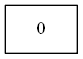

In [27]:
ddf_1.visualize()

In [30]:
ddf_1.divisions

(0, 9)

In [34]:
ddf_1.npartitions

1

In [23]:
ddf_2 = dd.from_pandas(pdf, npartitions = 2)

In [24]:
ddf_2

,Person ID,Last Name,First Name,Date of Birth
npartitions=2,,,,
0,int64,object,object,object
5,...,...,...,...
9,...,...,...,...


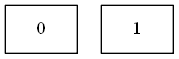

In [28]:
ddf_2.visualize()

In [32]:
ddf_2.divisions

(0, 5, 9)

In [35]:
ddf_2.npartitions

2

In [25]:
ddf_3 = dd.from_pandas(pdf, npartitions = 3)

In [26]:
ddf_3

,Person ID,Last Name,First Name,Date of Birth
npartitions=3,,,,
0,int64,object,object,object
4,...,...,...,...
8,...,...,...,...
9,...,...,...,...


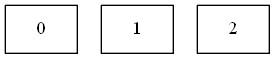

In [29]:
ddf_3.visualize()

In [33]:
ddf_3.divisions

(0, 4, 8, 9)

In [36]:
ddf_3.npartitions

3

A couple useful attributes of Dask DataFrames that can be
used to inspect how a DataFrame is partitioned. The first attribute,
**divisions**, (0, 5, 9), shows the boundaries of the partitioning scheme
(remember that partitions are created on the index). This might look strange
since there are two partitions but three boundaries. Each partition’s
boundary consists of pairs of numbers from the list of divisions. The
boundary for the first partition is “from 0 up to (but not including) 5,”
meaning it will contain rows 0, 1, 2, 3, and 4. The boundary for the second
partition is “from 5 through (and including) 9,” meaning it will contain rows
5, 6, 7, 8, and 9. The last partition always includes the upper boundary,
whereas the other partitions go up to but don’t include their upper boundary.

The second attribute, **npartitions**, simply returns the number of partitions
that exist in the DataFrame.

Use the **map_partitions( )** method to count the
number of rows in each partition. map_partitions generally applies a given
function to each partition. This means that the result of the map_partitions
call will return a Series equal in size to the number of partitions the
DataFrame currently has. Since ddf_2 has two partitions in this DataFrame, we
get two items back in the result of the call. The output shows that each
partition contains five rows, meaning Dask split the DataFrame into two
equal pieces

In [37]:
ddf_1.map_partitions(len)

Dask Series Structure:
npartitions=1
0    int64
9      ...
dtype: int64
Dask Name: len, 2 tasks

In [38]:
ddf_1.map_partitions(len).compute()

0    10
dtype: int64

In [39]:
ddf_2.map_partitions(len).compute()

0    5
1    5
dtype: int64

In [41]:
ddf_3.map_partitions(len).compute()

0    4
1    4
2    2
dtype: int64

Sometimes it may be necessary to change the number of partitions in a
Dask DataFrame. Particularly when your computations include a substantialamount of filtering, the size of each partition can become imbalanced, which
can have negative performance consequences on subsequent computations.
The reason for this is because if one partition suddenly contains a majority of
the data, all the advantages of parallelism are effectively lost.
Let’s look at an
example of this. First, we’ll derive a new DataFrame by applying a filter to
our original DataFrame that removes all people with the last name Williams.
We’ll then inspect the makeup of the new DataFrame by using the same
map_partitions call to count the rows per partition.

In [42]:
ddf_filtered = ddf_2[ddf_2['Last Name'] != 'Williams']

In [43]:
ddf_filtered

,Person ID,Last Name,First Name,Date of Birth
npartitions=2,,,,
0,int64,object,object,object
5,...,...,...,...
9,...,...,...,...


In [44]:
ddf_filtered.map_partitions(len).compute()

0    3
1    5
dtype: int64

In [45]:
ddf_filtered_reduced = ddf_filtered.repartition(npartitions = 1)

In [46]:
ddf_filtered_reduced

,Person ID,Last Name,First Name,Date of Birth
npartitions=1,,,,
0,int64,object,object,object
9,...,...,...,...


In [47]:
ddf_filtered_reduced.map_partitions(len).compute()

0    8
dtype: int64

Notice what happened: the first partition now only contains three rows, and
the second partition has the original five. People with the last name of
Williams happened to be in the first partition, so our new DataFrame has
become rather unbalanced.

The second two lines of code in the listing aim to fix the imbalance by
using the repartition method on the filtered DataFrame. The npartitions
argument here works the same way as the npartitions argument used
earlier when we created the initial DataFrame. Simply specify the number of
partitions you want and Dask will figure out what needs to be done to make
it so. If you specify a lower number than the current number of partitions,
Dask will combine existing partitions by concatenation. If you specify a
higher number than the current number of partitions, Dask will split existing
partitions into smaller pieces. You can call repartition at any time in your
program to initiate this process. However, like all other Dask operations, it’s
a **lazy computation**. No data will actually get moved around until you make a
call such as **compute**, **head**, and so on. Calling the map_partitions function
again on the new DataFrame, we can see that the number of partitions has
been reduced to one, and it contains all eight of the rows.

### **SHUFFLE**

In
distributed computing, the shuffle is the process of broadcasting all
partitions to all workers. Shuffling the data is necessary when performing
sorting, grouping, and indexing operations, because each row needs to be
compared to every other row in the entire DataFrame to determine its correct
relative position. This is a time-expensive operation, because it necessitates
transferring large amounts of data over the network. 

In ddf_2, we'll see what would happen with our DataFrame if we
want to group our data by Last Name. For example, we might want to find
the eldest person by last name. For the majority of the data, it’s no problem.
Most of the last names in this dataset are unique. As you can see in ddf_2, there are only two cases in which we have multiple people with
the same last name: Williams and Smith. For the two people named
Williams, they are in the same partition, so server 1 has all the information it
needs locally to determine that the oldest Williams was born in 1989.
However, for the people named Smith, there’s one Smith in partition 1 and
one Smith in partition 2. Either server 1 will have to send its Smith to server
2 to make the comparison, or server 2 will have to send server 1 its Smith. In
both cases, for Dask to be able to compare the birthdates of each Smith, one
of them will have to be shipped over the network.

Depending on what needs to be done with the data, completely avoiding
shuffle operations might not be feasible. However, you can do a few things to
minimize the need for shuffling the data. **First**, ensuring that the data is
stored in a presorted order will eliminate the need to sort the data with Dask.
If possible, sorting the data in a source system, such as a relational database,
can be faster and more efficient than sorting the data in a distributed system.
**Second**, using a sorted column as the DataFrame’s index will enable greater
efficiency with joins. When the data is presorted, lookup operations are very
fast because the partition where a certain row is kept can be easily
determined by using the divisions defined on the DataFrame. **Finally**, if you
must use an operation that triggers a shuffle, persist the result if you have
the resources to do so. This will prevent having to repeat shuffling the data
again if the DataFrame needs to be recomputed.

### **LIMITATIONS OF DASK DATAFRAMEs**

**First** and foremost, Dask DataFrames do not expose the entire Pandas API.
Even though Dask DataFrames are made up of smaller Pandas DataFrames,
some functions that Pandas does well are simply not conducive to a
distributed environment. For example, functions that would alter the
structure of the DataFrame, such as insert and pop, are not supported
because Dask DataFrames are immutable. Some of the more complex
window operations are also not supported, such as expanding and EWM
methods, as well as complex transposition methods like stack/unstack and
melt, because of their tendency to cause a lot of data shuffling. Oftentimes,
these expensive operations don’t really need to be performed on the full, raw
dataset. In those cases, you should use Dask to do all your normal data prep,
filtering, and transformation, then dump the final dataset into Pandas. You
will then be able to perform the expensive operations on the reduced dataset.
Dask’s DataFrame API makes it very easy to interoperate with Pandas
DataFrames, so this pattern can be very useful when analyzing data using
Dask DataFrames.

The **second** limitation is with relational-type operations, such as
join/merge, groupby, and rolling. Although these operations are supported,
they are likely to involve a lot of shuffling, making them performance
bottlenecks. This can be minimized, again, either by using Dask to prepare a
smaller dataset that can be dumped into Pandas, or by limiting these
operations to only use the index. For example, if we wanted to join a
DataFrame of people to a DataFrame of transactions, that computationwould be significantly faster if both datasets were sorted and indexed by the
Person ID. This would minimize the likelihood that each person’s records are
spread out across many partitions, in turn making shuffles more efficient.

**Third**, indexing has a few challenges due to the distributed nature of Dask.
If you wish to use a column in a DataFrame as an index in lieu of the default
numeric index, it will need to be sorted. If the data is stored presorted, this
becomes no problem at all. If the data is not presorted, it can be very slow to
sort the entire DataFrame because it requires a lot of shuffling. Effectively,
each partition first needs to be sorted, then needs to be merged and sorted
again with every other partition. Sometimes it may be necessary to do this,
but if you can proactively store your data presorted for the computations you
need, it will save you a lot of time.

The **other** significant difference you may notice with indexing is how Dask
handles the reset_index method. Unlike Pandas, where this will recalculate
a new sequential index across the entire DataFrame, the method in Dask
DataFrames behaves like a map_partitions call. This means that each
partition will be given its own sequential index that starts at 0, so the whole
DataFrame will no longer have a unique sequential index.

In ddf_2, each partition contained five rows, so once we called reset_index, the index
of the first five rows remains the same, but the next five rows, which are
contained in the next partition, start over at 0. Unfortunately, there’s no easy
way to reset the index in a partition-aware way. Therefore, use the
reset_index method carefully and only if you don’t plan to use the resulting
sequential index to join, group, or sort the DataFrame.

**Finally**, since a Dask DataFrame is made up of many Pandas DataFrames,
operations that are inefficient in Pandas will also be inefficient in Dask. For
example, iterating over rows by using the apply and iterrows methods is
notoriously inefficient in Pandas. Therefore, following Pandas best practices
will give you the best performance possible when using Dask DataFrames.